In [1]:

from Interpolation_frequency.dataset import SineMixDataset

In [2]:
import matplotlib.pyplot as plt
import dataset
import importlib
importlib.reload(dataset)
import matplotlib.pyplot as plt


# assuming SineMixDataset is already defined/imported
ds = dataset.SineMixDataset(
    n=10, T=100, duration=1.0,
    freqs=[1,5],
    n_components=2,
    noise_std=0.11,
    n_obs=40,
    # n_obs_range=(4,10),
    seed=42
)



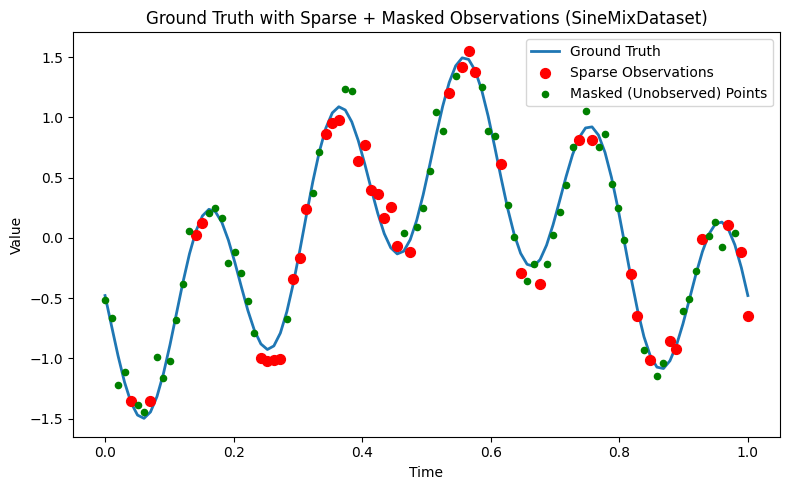

In [4]:
# Pick a sample (similar to your index=1000 example)
index =20
sample = ds[index]

# unpack (use feature 0 since it's univariate)
dense_positions = sample["positions"].squeeze(0).numpy()          # (T,)
ground_truth    = sample["ground_truth"][:, 0].numpy()            # (T,)
values          = sample["values"][:, 0].numpy()                  # (T,)
observed_mask   = ~sample["mask"].numpy().astype(bool)            # True = observed
masked_mask     = sample["mask"].numpy().astype(bool)                                # True = unobserved (masked)

# build sparse positions/values from the observed mask (red)
sparse_positions = dense_positions[observed_mask]
sparse_values    = values[observed_mask]

plt.figure(figsize=(8, 5))
plt.plot(dense_positions, ground_truth, label="Ground Truth", linewidth=2)
plt.scatter(sparse_positions, sparse_values, color='red', label="Sparse Observations",
            s=50, zorder=5)
plt.scatter(dense_positions[masked_mask], values[masked_mask], color='green',
            label="Masked (Unobserved) Points", s=20, zorder=5)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Ground Truth with Sparse + Masked Observations (SineMixDataset)")
plt.legend()
plt.tight_layout()
plt.show()

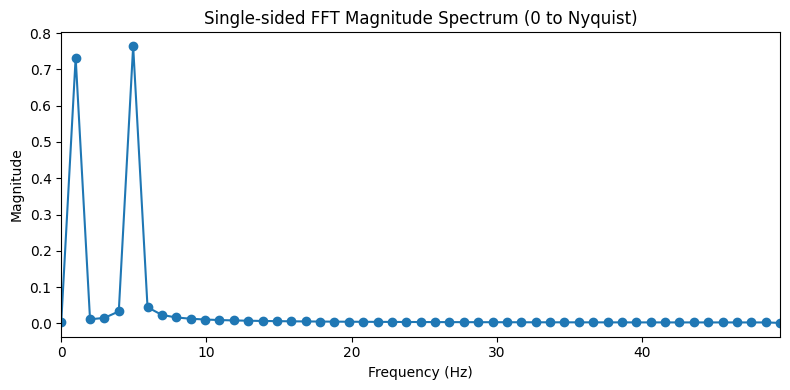

In [5]:
import numpy as np

# sample spacing and length
dt = dense_positions[1] - dense_positions[0]
N = ground_truth.size

# use rfft/rfftfreq to get only non-negative frequencies up to Nyquist
gt_fft = np.fft.rfft(ground_truth)
gt_freqs = np.fft.rfftfreq(N, d=dt)

# compute single-sided magnitude spectrum and normalize (optional amplitude scaling)
magnitude = np.abs(gt_fft) / N
if N % 2 == 0:
    # even N: Nyquist bin exists and should not be doubled
    magnitude[1:-1] *= 2
else:
    magnitude[1:] *= 2

plt.figure(figsize=(8, 4))
plt.plot(gt_freqs, magnitude, marker='o')
plt.title("Single-sided FFT Magnitude Spectrum (0 to Nyquist)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, gt_freqs[-1])  # ensure we only plot up to Nyquist
plt.tight_layout()
plt.show()


# Evaluations

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

from romae.model import (RoMAEForPreTraining, RoMAEForPreTrainingConfig)
from romae.utils import get_encoder_size, load_from_checkpoint

# import your dataset class
from dataset import SineMixDataset

def make_loaders_for_sparsity(n, T, duration, freqs, n_components, noise_std, seed, n_obs_values, batch_size=1):
    """Create a dict {n_obs: DataLoader} with fixed n_obs per split."""
    loaders = {}
    datasets = {}
    for n_obs in n_obs_values:
        ds = SineMixDataset(
            n=n, T=T, duration=duration,
            freqs=freqs, n_components=n_components,
            noise_std=noise_std,
            n_obs=n_obs,              # fixed sparsity per dataset
            seed=seed
        )
        datasets[n_obs] = ds
        loaders[n_obs] = DataLoader(ds, batch_size=batch_size, shuffle=False)
    return datasets, loaders

def evaluate_sinemix_mse(checkpoint_path, n=400, T=100, duration=1.0,
                         freqs=(1,5,20,35,45), n_components=3, noise_std=0.1,
                         seed=42, n_obs_values=(5,10,20)):
    # model
    _ = get_encoder_size("RoMAE-tiny")  # if you need this side-effect; kept for parity
    model = load_from_checkpoint(checkpoint_path, RoMAEForPreTraining, RoMAEForPreTrainingConfig)
    model.set_loss_fn(nn.MSELoss(reduction='mean'))
    model.eval()
    model.cuda() if torch.cuda.is_available() else None

    # data
    datasets, loaders = make_loaders_for_sparsity(
        n=n, T=T, duration=duration,
        freqs=freqs, n_components=n_components,
        noise_std=noise_std, seed=seed,
        n_obs_values=n_obs_values, batch_size=1
    )

    results = {k: {"loss": 0.0, "predictions": []} for k in n_obs_values}

    with torch.no_grad():
        for n_obs in n_obs_values:
            for batch in loaders[n_obs]:
                # move to device
                device = next(model.parameters()).device
                batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

                # forward
                pred, ll = model(**batch)  # pred shape depends on model; commonly (B,T,C,?,?)
                results[n_obs]["loss"] += ll.item()
                results[n_obs]["predictions"].append(pred.detach().cpu())

    # aggregate
    MSE = {k: results[k]["loss"] / len(datasets[k]) for k in n_obs_values}
    predictions = {k: results[k]["predictions"] for k in n_obs_values}
    return datasets, predictions, MSE

def evaluate_sinemix_msearray(checkpoint_path, n=400, T=100, duration=1.0,
                         freqs=(1,5,20,35,45), n_components=3, noise_std=0.1,
                         seed=42, n_obs_values=(5,10,20)):
    # model
    _ = get_encoder_size("RoMAE-tiny")  # if you need this side-effect; kept for parity
    model = load_from_checkpoint(checkpoint_path, RoMAEForPreTraining, RoMAEForPreTrainingConfig)
    model.set_loss_fn(nn.MSELoss(reduction='none'))
    model.eval()
    model.cuda() if torch.cuda.is_available() else None

    # data
    datasets, loaders = make_loaders_for_sparsity(
        n=n, T=T, duration=duration,
        freqs=freqs, n_components=n_components,
        noise_std=noise_std, seed=seed,
        n_obs_values=n_obs_values, batch_size=1
    )

    results = {k: {"loss": [], "predictions": []} for k in n_obs_values}

    with torch.no_grad():
        for n_obs in n_obs_values:
            for batch in loaders[n_obs]:
                # move to device
                device = next(model.parameters()).device
                batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

                # forward
                pred, ll = model(**batch)  # pred shape depends on model; commonly (B,T,C,?,?)
                results[n_obs]["loss"].append(ll.item())
                results[n_obs]["predictions"].append(pred.detach().cpu())

    # aggregate
    MSE = {k: results[k]["loss"] for k in n_obs_values}
    predictions = {k: results[k]["predictions"] for k in n_obs_values}
    return datasets, predictions, MSE

import matplotlib.pyplot as plt
import numpy as np

def _to_cpu_np(x):
    if torch.is_tensor(x): x = x.detach().cpu().numpy()
    return np.asarray(x)

def _to_np(x):
    import numpy as np, torch
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _squeeze_gt(x):  # handles (T,1,1,1) or (T,1) → (T,)
    import numpy as np
    x = _to_np(x)
    return x.reshape(x.shape[0], -1)[:, 0]

def plot_panel_sinemix(datasets, predictions, n_obs_values=(5,10,20), sample_index=2, title_suffix=""):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, len(n_obs_values), figsize=(18, 5), sharey=True)
    if len(n_obs_values) == 1:
        axes = [axes]

    for ax, n_obs in zip(axes, n_obs_values):
        sample = datasets[n_obs][sample_index]

        # unpack
        t          = _to_np(sample["positions"]).squeeze(0)                    # (T,)
        values     = _squeeze_gt(sample["values"])                              # (T,)
        x_clean    = _squeeze_gt(sample["ground_truth"])                        # (T,)

        # mask semantics: mask=True means observed
        mask_obs   = _to_np(sample["mask"]).astype(bool).reshape(-1)            # (T,)
        mask_miss  = (mask_obs)                                                # (T,)

        # sparse obs from noisy values
        sparse_positions = t[~mask_obs]
        sparse_values    = values[~mask_obs]

        # pull prediction tensor for this sample
        pred_tensor = predictions[n_obs][sample_index]   # list element from evaluation
        pred = _to_np(pred_tensor).squeeze()

        # make a 1-D series
        pred_flat = pred.reshape(-1)
        T = t.shape[0]
        n_miss = int(mask_miss.sum())

        # choose alignment
        if pred_flat.size == n_miss:
            # model predicted only missing points, in time order
            t_pred = t[mask_miss]
            y_pred = pred_flat
        elif pred_flat.size == T:
            # model predicted full trajectory
            t_pred = t[mask_miss]
            y_pred = pred_flat[mask_miss]
        else:
            # unexpected shape; print and skip plotting predictions
            print(f"[warn] unexpected pred size {pred_flat.size}; T={T}, n_miss={n_miss}")
            t_pred, y_pred = None, None

        # plot
        ax.plot(t, x_clean, label="Ground Truth", linewidth=2, color="tab:blue")
        ax.scatter(sparse_positions, sparse_values, color='red',
                   label="Sparse Observations", s=50, zorder=5)
        ax.scatter(t[mask_miss], values[mask_miss], color='green',
                   label="Masked (Unobserved) Points", s=18, zorder=5)

        if y_pred is not None:
            ax.scatter(t_pred, y_pred, color='orange',
                    label="Predicted (masked region)", linewidth=2)
            ax.plot(t_pred, y_pred, color='orange', linewidth=2)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.set_title(f"n_obs = {n_obs}{title_suffix}")
        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

import numpy as np
import torch
import matplotlib.pyplot as plt

def _to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _single_sided_mag(y, dt):
    """
    Single-sided magnitude spectrum with standard amplitude scaling:
    - rfft magnitudes divided by N
    - double non-DC and non-Nyquist bins (if N even)
    """
    y = np.asarray(y)
    N = y.size
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(N, d=dt)
    mag = np.abs(Y) / N
    if N % 2 == 0:
        # even N: Nyquist bin exists and should not be doubled
        if N > 2:
            mag[1:-1] *= 2.0
    else:
        if N > 1:
            mag[1:] *= 2.0
    return freqs, mag

def fft_compare_sample(sample, pred_tensor, title_suffix=""):
    """
    Compare FFT of ground truth vs model prediction for a single sample.
    - sample: one item from SineMixDataset
    - pred_tensor: the prediction returned by your model for that sample
                   (either full (T,1[,1,1]) or only-missing (n_miss,))
    """
    # --- unpack sample ---
    t         = _to_np(sample["positions"]).squeeze(0)              # (T,)
    x_clean   = _to_np(sample["ground_truth"])                       # (T,1,1,1) or (T,1)
    x_clean   = x_clean.reshape(x_clean.shape[0], -1)[:, 0]          # (T,)
    x_noisy   = _to_np(sample["values"]).reshape(len(t), -1)[:, 0]   # (T,) (used only if we need to fill observed points)
    mask_obs  = _to_np(sample["mask"]).astype(bool).reshape(-1)      # (T,)  True = observed
    mask_miss = mask_obs                                            # (T,)  True = missing
    T         = len(t)
    dt        = t[1] - t[0]

    # --- normalize pred to 1D numpy ---
    pred = _to_np(pred_tensor).squeeze()

    # --- reconstruct a full-length prediction on the same grid ---
    if pred.size == T:
        # full trajectory predicted
        y_hat_full = pred
    elif pred.size == int(mask_miss.sum()):
        # only missing positions predicted — fill them
        y_hat_full = x_noisy.copy()  # keep observed points as the actually observed (noisy) values
        # assume predictions are in time order for the missing indices:
        y_hat_full[mask_miss] = pred
    else:
        raise ValueError(f"Unexpected prediction size {pred.size}; T={T}, missing={mask_miss.sum()}.")

    # --- FFTs (single-sided) ---
    f_gt, mag_gt   = _single_sided_mag(x_clean, dt)
    f_ph, mag_pred = _single_sided_mag(y_hat_full, dt)

    # --- time-domain (optional small plot) + frequency-domain comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Time domain: show GT and reconstruction
    axes[0].plot(t, x_clean, label="Ground Truth", lw=2)
    axes[0].plot(t, y_hat_full, label="Prediction (full)", alpha=0.8)
    # For context, show sparse observed points (red)
    axes[0].scatter(t[mask_obs], x_noisy[mask_obs], s=18, color="red", label="Observed pts", zorder=5)
    axes[0].set_title(f"Time domain {title_suffix}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Value")
    axes[0].legend()

    # Frequency domain: single-sided spectra
    axes[1].plot(f_gt, mag_gt, marker='o', label="GT spectrum")
    axes[1].plot(f_ph, mag_pred, marker='x', label="Pred spectrum")
    axes[1].set_title("Single-sided FFT magnitude (0..Nyquist)")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlim(0, f_gt[-1])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [62]:

datasets, preds, MSEs = evaluate_sinemix_mse(
    checkpoint_path="../checkpoints/checkpoint-9550",
    n=400, T=100, duration=1.0,
    freqs=(7, 22),
    n_components=2,
    noise_std=0.1,
    seed=56,
    n_obs_values=(50,)   # note the comma
)



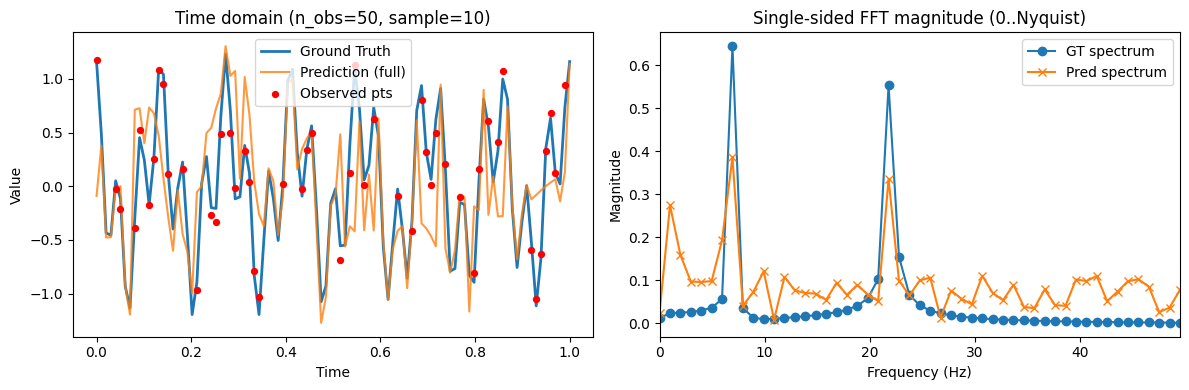

In [63]:
# pick a sparsity regime and sample index
n_obs = 50  # or 5, 10, 20 ...
sample_idx = 10

sample = datasets[n_obs][sample_idx]
pred_tensor = preds[n_obs][sample_idx]  # a tensor from evaluation

fft_compare_sample(sample, pred_tensor, title_suffix=f"(n_obs={n_obs}, sample={sample_idx})")

In [65]:
pred_tensor.shape

torch.Size([1, 50, 1])

In [4]:
def get_two_fft(sample, pred_tensor):
    """
    Compare FFT of ground truth vs model prediction for a single sample.
    - sample: one item from SineMixDataset
    - pred_tensor: the prediction returned by your model for that sample
                   (either full (T,1[,1,1]) or only-missing (n_miss,))
    """
    # --- unpack sample ---
    t         = _to_np(sample["positions"]).squeeze(0)              # (T,)
    x_clean   = _to_np(sample["ground_truth"])                       # (T,1,1,1) or (T,1)
    x_clean   = x_clean.reshape(x_clean.shape[0], -1)[:, 0]          # (T,)
    x_noisy   = _to_np(sample["values"]).reshape(len(t), -1)[:, 0]   # (T,) (used only if we need to fill observed points)
    mask_obs  = _to_np(sample["mask"]).astype(bool).reshape(-1)      # (T,)  True = observed
    mask_miss = mask_obs                                            # (T,)  True = missing
    T         = len(t)
    dt        = t[1] - t[0]

    # --- normalize pred to 1D numpy ---
    pred = _to_np(pred_tensor).squeeze()

    # --- reconstruct a full-length prediction on the same grid ---
    if pred.size == T:
        # full trajectory predicted
        y_hat_full = pred
    elif pred.size == int(mask_miss.sum()):
        # only missing positions predicted — fill them
        y_hat_full = x_noisy.copy()  # keep observed points as the actually observed (noisy) values
        # assume predictions are in time order for the missing indices:
        y_hat_full[mask_miss] = pred
    else:
        raise ValueError(f"Unexpected prediction size {pred.size}; T={T}, missing={mask_miss.sum()}.")

    # --- FFTs (single-sided) ---
    f_gt, mag_gt   = _single_sided_mag(x_clean, dt)
    f_ph, mag_pred = _single_sided_mag(y_hat_full, dt)

    return f_gt, f_ph, mag_gt, mag_pred
    
    # --- time-domain (optional small plot) + frequency-domain comparison ---
    # fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # # Frequency domain: single-sided spectra
    # axes[1].plot(f_gt, mag_gt, marker='o', label="GT spectrum")
    # axes[1].plot(f_ph, mag_pred, marker='x', label="Pred spectrum")
    # axes[1].set_title("Single-sided FFT magnitude (0..Nyquist)")
    # axes[1].set_xlabel("Frequency (Hz)")
    # axes[1].set_ylabel("Magnitude")
    # axes[1].set_xlim(0, f_gt[-1])
    # axes[1].legend()

    # plt.tight_layout()
    # plt.show()

In [18]:
# 
## ACTUALLY FOR NOW ITS ONLY BEEN TRAINED ON 1,5?!?
training_freq = np.array([1, 3, 5, 7, 9, 12, 15, 18, 21, 24])
test_freq  = np.arange(1,25)

In [5]:
import time

In [23]:
n_obs_val = 50  # or 5, 10, 20 ...
nb_ex = 200

fft_preds, fft_truts = {}, {}
f_pred, f_truths = {}, {}

for tf in training_freq:
    datasets, preds, MSEs = evaluate_sinemix_mse(
        checkpoint_path="../checkpoints/checkpoint-9550",
        n=nb_ex, T=100, duration=1.0,
        freqs=(tf),
        n_components=1,
        noise_std=0.1, 
        n_obs_values=(n_obs_val,),
        seed=27
        # note the comma
    )
    fft_preds[tf]=[]
    fft_truts[tf]=[]
    f_pred[tf]=[]
    f_truths[tf]=[]

    t=time.time()
    for si in range(nb_ex):
        
        sample = datasets[n_obs_val][si]
        pred_tensor = preds[n_obs_val][si]  # a tensor from evaluation
        
        f_gt, f_ph, mag_gt, mag_pred = get_two_fft(sample, pred_tensor)
        fft_preds[tf].append(mag_pred)
        fft_truts[tf].append(mag_gt)
        ## Useless to keep all but was to check I can kosherly make the MSE
        f_pred[tf].append(f_ph)
        f_truths[tf].append(f_gt)
    print(time.time()-t)

0.05084085464477539
0.05026888847351074
0.05113720893859863
0.05086183547973633
0.05066847801208496
0.05080986022949219
0.0507967472076416
0.05069899559020996
0.050595998764038086
0.05060315132141113


In [52]:
mean_mse_fullfft, std_mse_fullfft = [], []
mean_mse_atfreq, std_mse_atfreq = [], []

for tf in training_freq:
    mean_mse_fullfft.append(np.mean(np.mean((np.array(fft_preds[tf]) - np.array(fft_truts[tf]))**2, axis=1)))
    std_mse_fullfft.append(np.std(np.mean((np.array(fft_preds[tf]) - np.array(fft_truts[tf]))**2, axis=1)))

    assert np.sum(np.array(f_pred[tf]) - np.array(f_truths[tf]))==0
    idc_freq = np.argmin(np.abs(np.array(f_pred[tf])[0] - tf))
    print(idc_freq)
    mean_mse_atfreq.append(np.mean((np.array(fft_preds[tf])[:, idc_freq] - np.array(fft_truts[tf])[:,idc_freq])**2))
    std_mse_atfreq.append(np.std((np.array(fft_preds[tf])[:,idc_freq] - np.array(fft_truts[tf])[:, idc_freq])**2))


1
3
5
7
9
12
15
18
21
24


Text(0.5, 0, 'Frequency (Hz)')

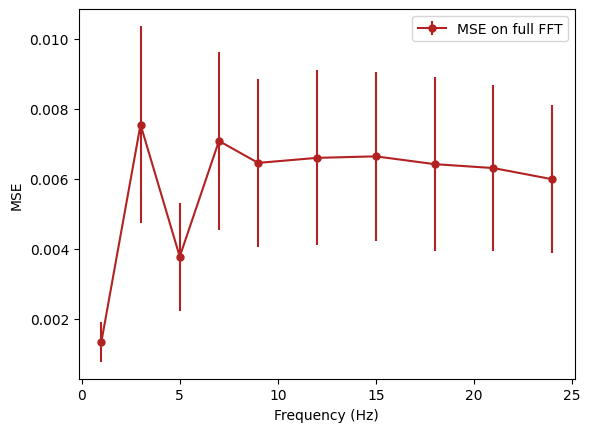

In [56]:
plt.errorbar(training_freq,mean_mse_fullfft,
             yerr=std_mse_fullfft, marker='o', ms=5, color='firebrick', label='MSE on full FFT')

# plt.errorbar(training_freq, mean_mse_atfreq,
#              yerr=std_mse_atfreq, marker='o', ms=5, color='darkblue', label='MSE on FFT at specific frequency')

plt.legend()
plt.ylabel("MSE")
plt.xlabel("Frequency (Hz)")

In [50]:
np.array(fft_preds[tf])[:, idc_freq].shape

(200,)

In [48]:
np.mean(np.mean((np.array(fft_preds[tf])[:, idc_freq] - np.array(fft_truts[tf])[:,idc_freq])**2, axis=1))

array([2.96691690e-03, 3.45257736e-04, 1.92822238e-02, 1.12276033e-03,
       1.22607478e-03, 3.15608249e-03, 3.35347844e-03, 5.17260074e-03,
       2.73564250e-03, 3.83280734e-03, 1.51346058e-02, 2.77646797e-06,
       5.34797553e-03, 8.86575033e-03, 1.91657040e-02, 7.85736401e-03,
       8.76365670e-03, 2.46986578e-03, 1.18889213e-02, 5.05902578e-04,
       9.47549645e-03, 8.29541269e-04, 5.70865070e-03, 8.66762546e-03,
       2.96156536e-03, 5.73517198e-05, 2.32002288e-03, 2.07082594e-04,
       2.05267651e-02, 2.05361119e-03, 4.01780774e-03, 9.80547950e-05,
       4.45764918e-03, 1.26233289e-02, 5.19803618e-03, 4.58201515e-03,
       3.70520357e-03, 1.26005748e-03, 8.28481588e-03, 1.19551397e-02,
       2.38340696e-03, 1.34113270e-02, 1.71798328e-03, 2.99772938e-03,
       1.76726694e-04, 3.40579893e-03, 9.80701285e-04, 6.16114807e-04,
       2.59820206e-03, 1.05945280e-03, 9.63758931e-03, 5.00684087e-03,
       3.52489069e-03, 2.46195783e-03, 8.22089907e-04, 3.59239902e-03,
      

In [66]:
## Pretrain on more frequencies

In [6]:
from romae.model import (RoMAEForPreTraining,RoMAEForPreTrainingConfig, EncoderConfig)
from romae.trainer import Trainer, TrainerConfig
from romae.utils import get_encoder_size
import torch.nn as nn

from Interpolation_frequency.dataset import SineMixDataset


def pretrain_freqarg(freqs, ncomponents, nobs, sizetrain, sizetest, T=100):
    # Let's use the tiny model:
    encoder_args = get_encoder_size("RoMAE-tiny")
    decoder_args = get_encoder_size("RoMAE-tiny")

    model_config = RoMAEForPreTrainingConfig(
        encoder_config=EncoderConfig(**encoder_args),
        decoder_config=EncoderConfig(**decoder_args),
        tubelet_size=(1, 1, 1),
        n_channels=1,
        n_pos_dims=1,
        use_cls = True,      # Relative position embedding,
        p_rope_val = 0.75     # Default is 0.75
    )

    # HAve beelow in the ENV (not everything)
    model          = RoMAEForPreTraining(model_config)
    model.set_loss_fn(nn.MSELoss())
    trainer_config = TrainerConfig(project_name="Interpolation_frequency_morefreq",
                                  checkpoint_dir="/scratch/gcontard/RoMAE_expe_interpfreqmore_freq/"+"_checkpoint_",
        epochs=200, #config.pretrain_epochs,
        base_lr= 4e-4,
        eval_every=300,
        save_every=300,
        #optimizer_args=config.pretrain_optimargs,
        batch_size=248,
        entity_name='contardog-university-of-nova-gorica',
        #gradient_clip=config.pretrain_grad_clip,)
                                  )
    trainer       = Trainer(trainer_config)
    train_dataset  = SineMixDataset(n=sizetrain, T=T, duration=1.0,
                                    freqs=freqs,n_components=ncomponents, noise_std=0.1, n_obs=nobs, n_obs_range=None, seed=42)
    test_dataset   = SineMixDataset(n=sizetest, T=T, duration=1.0,
                                    freqs=freqs,n_components=ncomponents, noise_std=0.1, n_obs=nobs, n_obs_range=None, seed=43)
    trainer.train(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        model=model,
    )


In [7]:
# freqs = np.arange(1,21)
# ncomponents = [1,2]

# sizetrain=5000
# sizetest=500

# T = 300
# nobs= int(T/2)

# pretrain_freqarg(freqs, ncomponents, nobs, sizetrain, sizetest, T)

In [8]:

training_freq = np.array([1, 3, 5, 7, 9, 12, 15, 18, 21, 24])


In [31]:
n_obs_val = 50  # or 5, 10, 20 ...
nb_ex = 200

fft_preds, fft_truts = {}, {}
f_pred, f_truths = {}, {}
mses_ts = {}

for tf in training_freq:
    datasets, preds, MSEs = evaluate_sinemix_msearray(
        checkpoint_path="/scratch/gcontard/RoMAE_expe_interpfreqmore_freq/_checkpoint_/checkpoint-4200/",
        n=nb_ex, T=100, duration=1.0,
        freqs=(tf),
        n_components=1,
        noise_std=0.1, 
        n_obs_values=(n_obs_val,),
        seed=27
        # note the comma
    )
    mses_ts[tf] = MSEs
    fft_preds[tf]=[]
    fft_truts[tf]=[]
    f_pred[tf]=[]
    f_truths[tf]=[]

    t=time.time()
    for si in range(nb_ex):
        
        sample = datasets[n_obs_val][si]
        pred_tensor = preds[n_obs_val][si]  # a tensor from evaluation
        
        f_gt, f_ph, mag_gt, mag_pred = get_two_fft(sample, pred_tensor)
        fft_preds[tf].append(mag_pred)
        fft_truts[tf].append(mag_gt)
        ## Useless to keep all but was to check I can kosherly make the MSE
        f_pred[tf].append(f_ph)
        f_truths[tf].append(f_gt)
    print(time.time()-t)

0.05171394348144531
0.05139279365539551
0.05331563949584961
0.05214381217956543
0.05127263069152832
0.051770925521850586
0.05251955986022949
0.053133249282836914
0.052403926849365234
0.0518643856048584


In [34]:
np.array(mses_ts[5][50]).shape

(200,)

In [22]:
# mses_array = np.array([mses_ts[tf][50] for tf in training_freq])
# mses_array

array([0.01397294, 0.01624657, 0.02127738, 0.02866676, 0.06119587,
       0.13862941, 0.16501794, 0.20751501, 0.25592395, 0.30776482])

In [ ]:
mean_mse_fullfft, std_mse_fullfft = [], []
mean_mse_atfreq, std_mse_atfreq = [], []
mean_mse_ts, std_mse_ts = [], []
for tf in training_freq:
    mean_mse_fullfft.append(np.mean(np.mean((np.array(fft_preds[tf]) - np.array(fft_truts[tf]))**2, axis=1)))
    std_mse_fullfft.append(np.std(np.mean((np.array(fft_preds[tf]) - np.array(fft_truts[tf]))**2, axis=1)))

    mean_mse_ts.append(np.mean(mses_ts[tf][n_obs_val]))
    std_mse_ts.append(np.std(mses_ts[tf][n_obs_val]))

    
    assert np.sum(np.array(f_pred[tf]) - np.array(f_truths[tf]))==0
    idc_freq = np.argmin(np.abs(np.array(f_pred[tf])[0] - tf))
    #print(idc_freq)
    mean_mse_atfreq.append(np.mean((np.array(fft_preds[tf])[:, idc_freq] - np.array(fft_truts[tf])[:,idc_freq])**2))
    std_mse_atfreq.append(np.std((np.array(fft_preds[tf])[:,idc_freq] - np.array(fft_truts[tf])[:, idc_freq])**2))


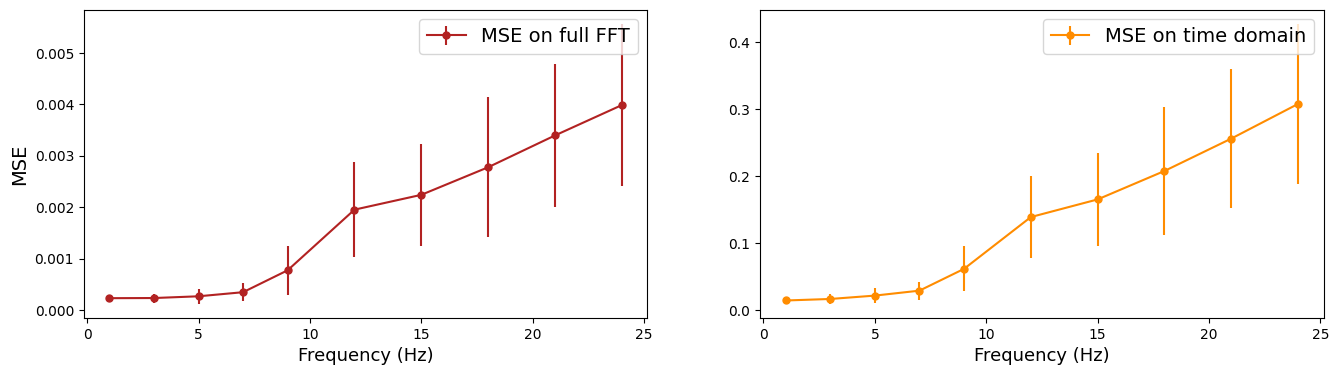

In [87]:
fig,axs =plt.subplots(1,2,figsize=(2*8,4))

axs[0].errorbar(training_freq,mean_mse_fullfft,
             yerr=std_mse_fullfft, marker='o', ms=5, color='firebrick', label='MSE on full FFT')
# axs[1].errorbar(training_freq, mean_mse_atfreq,
#               yerr=std_mse_atfreq, marker='o', ms=5, color='darkblue', label='MSE on FFT at specific frequency')

axs[1].errorbar(training_freq, mean_mse_ts,
           yerr=std_mse_ts, 
             marker='o', ms=5, color='darkorange', label='MSE on time domain')



axs[0].set_ylabel("MSE", fontsize=14)
for i in range(2):
    axs[i].set_xlabel("Frequency (Hz)", fontsize=13)
    axs[i].legend(fontsize=14)

plt.savefig(f"mse_one_freq_{n_obs_val}.pdf", dpi=150, bbox_inches='tight')

In [42]:
training_freq

array([ 1,  3,  5,  7,  9, 12, 15, 18, 21, 24])

In [51]:
## HeatMap of error for two components?



n_obs_val = 50  # or 5, 10, 20 ...
nb_ex = 200


fft_preds, fft_truts, mean_MSE_ffts = {}, {}, {}
f_pred, f_truths = {}, {}
mses_ts, mean_MSE_ts = {}, {}

for i in range(len(training_freq)):
    for j in range(i, len(training_freq)):
        tf1 = training_freq[i]
        tf2 = training_freq[j]
        datasets, preds, MSEs = evaluate_sinemix_msearray(
            checkpoint_path="/scratch/gcontard/RoMAE_expe_interpfreqmore_freq/_checkpoint_/checkpoint-4200/",
            n=nb_ex, T=100, duration=1.0,
            freqs=(tf1,tf2),
            n_components=2,
            noise_std=0.1, 
            n_obs_values=(n_obs_val,),
            seed=27
            # note the comma
        )
        mses_ts[(tf1,tf2)] = MSEs
        fft_preds[(tf1,tf2)]=[]
        fft_truts[(tf1,tf2)]=[]
        f_pred[(tf1,tf2)]=[]
        f_truths[(tf1,tf2)]=[]
    
        t=time.time()
        for si in range(nb_ex):
            
            sample = datasets[n_obs_val][si]
            pred_tensor = preds[n_obs_val][si]  # a tensor from evaluation
                
            f_gt, f_ph, mag_gt, mag_pred = get_two_fft(sample, pred_tensor)
            fft_preds[(tf1,tf2)].append(mag_pred)
            fft_truts[(tf1,tf2)].append(mag_gt)
            
        mean_MSE_ffts[(tf1,tf2)] = np.mean(np.mean((np.array(fft_preds[(tf1,tf2)]) - np.array(fft_truts[(tf1,tf2)]))**2, axis=1))
        mean_MSE_ts[(tf1,tf2)] = np.mean(MSEs[n_obs_val])
        ## Useless to keep all but was to check I can kosherly make the MSE
        # f_pred[(tf1,tf2)].append(f_ph)
        # f_truths[(tf1,tf2)].append(f_gt)
    print(time.time()-t)

0.05346202850341797
0.054314613342285156
0.05230975151062012
0.05260801315307617
0.05170750617980957
0.0513916015625
0.052510738372802734
0.05146360397338867
0.05167508125305176
0.05151700973510742


In [52]:

import seaborn as sns

In [53]:

# Create matrices for mean MSE values
n_freq = len(training_freq)
mse_fft_matrix = np.zeros((n_freq, n_freq))
mse_ts_matrix = np.zeros((n_freq, n_freq))

# Create matrices for standard deviations
std_fft_matrix = np.zeros((n_freq, n_freq))
std_ts_matrix = np.zeros((n_freq, n_freq))

# Fill the matrices
for i in range(n_freq):
    for j in range(i, n_freq):
        tf1 = training_freq[i]
        tf2 = training_freq[j]
        
        # Mean MSE (already computed)
        mse_fft_matrix[j, i] = mean_MSE_ffts[(tf1, tf2)]
        mse_ts_matrix[j, i] = mean_MSE_ts[(tf1, tf2)]
        
        # Compute standard deviations
        fft_mses = np.mean((np.array(fft_preds[(tf1, tf2)]) - np.array(fft_truts[(tf1, tf2)]))**2, axis=1)
        std_fft_matrix[j, i] = np.std(fft_mses)
        std_ts_matrix[j, i] = np.std(mses_ts[(tf1, tf2)][n_obs_val])




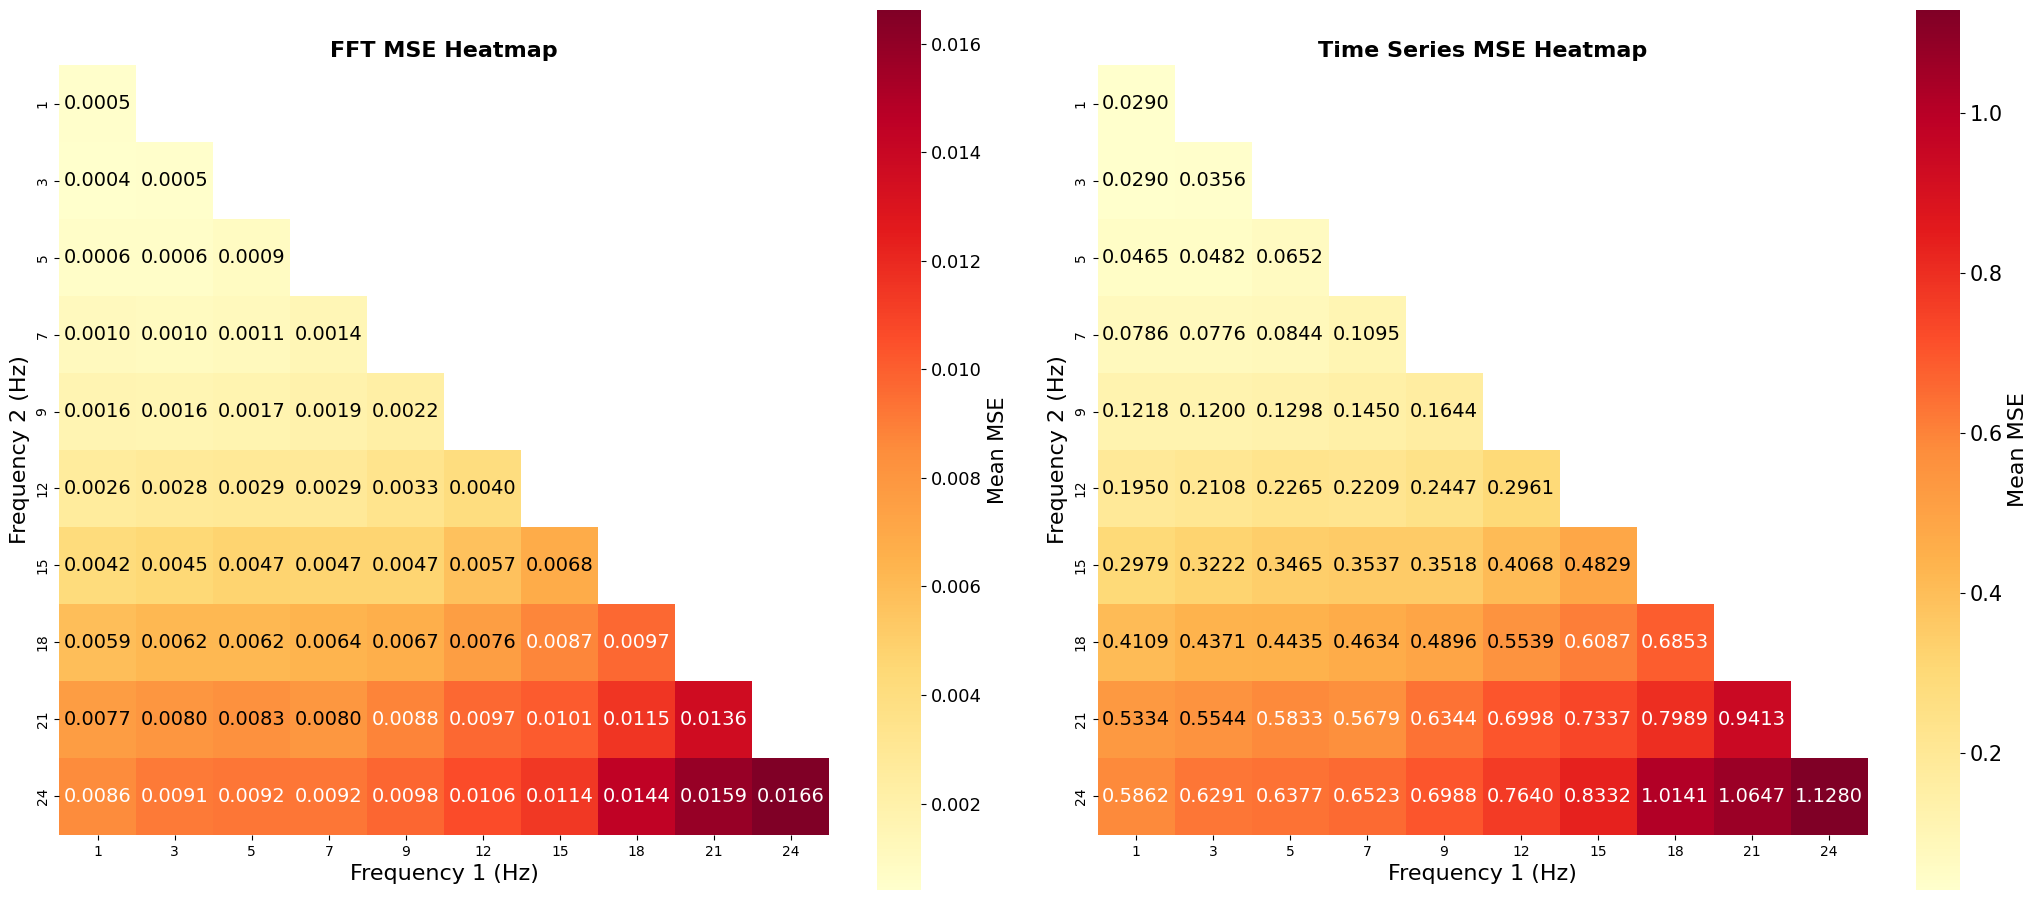


=== FFT MSE Summary ===
Mean: 5.9815e-03
Std:  4.2050e-03
Min:  4.0776e-04
Max:  1.6620e-02

=== Time Series MSE Summary ===
Mean: 4.2523e-01
Std:  2.8988e-01
Min:  2.8965e-02
Max:  1.1280e+00


In [80]:
# Mask upper triangle
mask = np.triu(np.ones_like(mse_fft_matrix, dtype=bool), k=1)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*1.3, 7*1.3))

# Heatmap 1: FFT MSE
h1 = sns.heatmap(mse_fft_matrix, mask=mask, annot=False, fmt='.2e', 
            cmap='YlOrRd', square=True, cbar_kws={'label': 'Mean MSE'},
            xticklabels=training_freq, yticklabels=training_freq, ax=ax1)
h1.figure.axes[-1].yaxis.label.set_size(15)

h1.figure.axes[-1].tick_params(labelsize=13)

# Add custom annotations with mean ± std
for i in range(n_freq):
    for j in range(i, n_freq):
        if j < n_freq:  # within bounds
            mean_val = mse_fft_matrix[j, i]
            std_val = std_fft_matrix[j, i]
            text = f'{mean_val:.4f}'
            ax1.text(i + 0.5, j + 0.5, text, ha='center', va='center', 
                    fontsize=14, color='black' if mean_val < np.nanmax(mse_fft_matrix)/2 else 'white')

ax1.set_title(f'FFT MSE Heatmap', fontsize=16, fontweight='bold')
ax1.set_xlabel('Frequency 1 (Hz)', fontsize=16)
ax1.set_ylabel('Frequency 2 (Hz)', fontsize=16)
# Heatmap 2: Time Series MSE
h2 = sns.heatmap(mse_ts_matrix, mask=mask, annot=False, fmt='.2e', 
            cmap='YlOrRd', square=True, cbar_kws={'label': 'Mean MSE'},
            xticklabels=training_freq, yticklabels=training_freq, ax=ax2)
h2.figure.axes[-1].yaxis.label.set_size(16)

h2.figure.axes[-1].tick_params(labelsize=15)

# Add custom annotations with mean ± std
for i in range(n_freq):
    for j in range(i, n_freq):
        if j < n_freq:
            mean_val = mse_ts_matrix[j, i]
            std_val = std_ts_matrix[j, i]
            text = f'{mean_val:.4f}'
            ax2.text(i + 0.5, j + 0.5, text, ha='center', va='center', 
                    fontsize=14, color='black' if mean_val < np.nanmax(mse_ts_matrix)/2 else 'white')

ax2.set_title(f'Time Series MSE Heatmap', fontsize=16, fontweight='bold')
ax2.set_xlabel('Frequency 1 (Hz)', fontsize=16)
ax2.set_ylabel('Frequency 2 (Hz)', fontsize=16)

plt.tight_layout()
plt.savefig(f'mse_heatmaps_nobs{n_obs_val}.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Optional: Print summary statistics
print("\n=== FFT MSE Summary ===")
print(f"Mean: {np.mean(mse_fft_matrix[~mask]):.4e}")
print(f"Std:  {np.std(mse_fft_matrix[~mask]):.4e}")
print(f"Min:  {np.min(mse_fft_matrix[~mask]):.4e}")
print(f"Max:  {np.max(mse_fft_matrix[~mask]):.4e}")

print("\n=== Time Series MSE Summary ===")
print(f"Mean: {np.mean(mse_ts_matrix[~mask]):.4e}")
print(f"Std:  {np.std(mse_ts_matrix[~mask]):.4e}")
print(f"Min:  {np.min(mse_ts_matrix[~mask]):.4e}")
print(f"Max:  {np.max(mse_ts_matrix[~mask]):.4e}")

In [59]:
!pwd

/u/g/gcontard/LSST_RepresentationLearning/RoMAE/RoMA-Experiments/Interpolation_frequency/Interpolation_frequency
